# human liver

## Preparation

In [1]:
import csv
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import STAGATE

In [4]:
from automatic_peak_picking_2D import automatic_2D_peak_picking
from TIC_normalization import SmartGate_TIC
from utils import convert_truth
from draw import plotCluster
from draw import plot_colortable

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot trust

Jupyter command `jupyter-nbconvert` not found.


## color setting

In [5]:
louvain_color = np.load('/home/emma/Smartgate/results/louvain_color20.npy')
SEAM_cls6 = np.load('/home/emma/Smartgate/results/human_liver/SEAM_cls6.npy')
louvain_color = louvain_color.tolist()
SEAM_cls6 = SEAM_cls6.tolist()

In [6]:
#color
#lightred, darkred, lightgreen, darkgreen, yellow, lightblue, darkblue, lightpink, darkpink, lightorange, darkorange
#HepaC1_!, HepaC1_2, HepaC2_1, HepaC2_2, Kupffer, Immune_1, Immune_2, Fibroblast_1, Fibroblast_2, Endo, New
smtgt_cls = [SEAM_cls6[0], louvain_color[0], SEAM_cls6[1], louvain_color[1], SEAM_cls6[2], SEAM_cls6[3], 
              louvain_color[5], SEAM_cls6[4],  louvain_color[3],SEAM_cls6[5], louvain_color[2]]

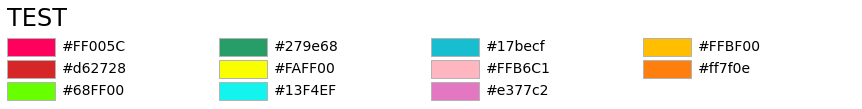

In [7]:
plot_colortable({a: a for a in smtgt_cls},"TEST", sort_colors = False);

## Load data

In [25]:
adata = sc.read_h5ad('/home/emma/SEAM-data/data/raw_tar/human_R1_raw.h5ad')
adata.raw = adata.copy()

In [26]:
top20 = pd.read_excel('/home/emma/SEAM-data/data/raw_tar/top20_corr.xlsx',index_col = 0)

In [27]:
#用IMS rawdata代替cell，修改obs.column
IMS = adata.uns['IMS']
Data1=pd.DataFrame(IMS)
mass=adata.var
mz=list(mass.index)
for i in range(len(mass)):
    Data1.rename(columns={i:mz[i]},inplace=True)
adata = sc.AnnData(Data1)

In [28]:
#增加spatial locations
loca=np.zeros((256*256,2))
for i in range(256):
    for j in range(256):
        loca[i*256+j]=[i,j]
adata.obsm['spatial'] = np.array(loca)

In [29]:
# Normalization
SmartGate_TIC(adata, c=200, log1p=True)

AnnData object with n_obs × n_vars = 65536 × 228
    obsm: 'spatial'

In [30]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
alpha = 0
pre_res=0.6
louvain_res =0.65
r = 1.7

ifpicking= 0
No peak picking, just run the graph-attention autoencoder
------Calculating spatial graph...
The graph contains 521220 edges, 65536 cells.
7.9532 neighbors per cell on average.
Size of Input:  (65536, 228)


100%|██████████| 1000/1000 [04:38<00:00,  3.60it/s]


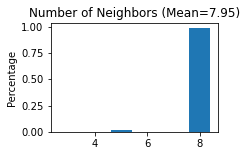

In [31]:
adata=automatic_2D_peak_picking(adata,ol_mass=len(adata.var),r=r, alpha=alpha, pre_resolutation=pre_res,
                                 n_epochs=1000, clust_method='louvain', k_resolutation=louvain_res)

In [32]:
adata.write('smartgate.h5ad')
print('smartgate.h5ad')

smartgate.h5ad


In [40]:
adata =sc.read_h5ad('/home/emma/Smartgate/results/human_liver/alpha0_preres0.6_louvain0.65_rad1.7/smartgate_louvain_reorder.h5ad')

In [41]:
# adata.obs['louvain'].cat.reorder_categories(['5','3','7','1','0','6','2','4','8'],inplace=True)
# adata.obs['louvain'] = adata.obs['louvain'].cat.rename_categories(['1','2','3','4','5','6','7','8','9'])
# adata.write(resdir/f'smartgate_louvain_reorder.h5ad')

In [42]:
adata.uns['louvain_colors'] = [smtgt_cls[1], smtgt_cls[0], smtgt_cls[10], smtgt_cls[2],smtgt_cls[9], smtgt_cls[4], smtgt_cls[5],smtgt_cls[7],smtgt_cls[8]]

In [43]:
#umap for raw count
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


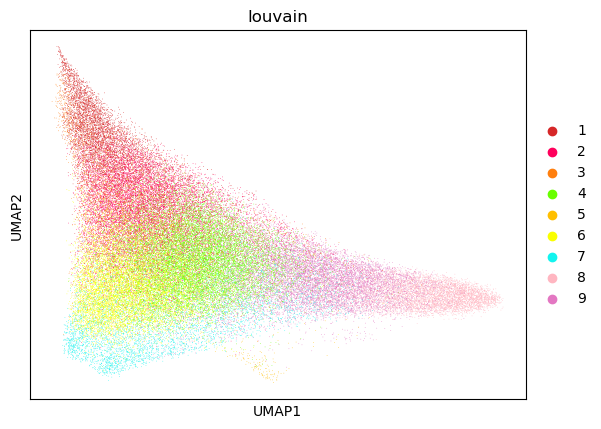

In [44]:
plt.rcParams.update(plt.rcParamsDefault)
sc.pl.umap(adata, color='louvain',size=1, show=True, save=f"-smartgate.pdf")

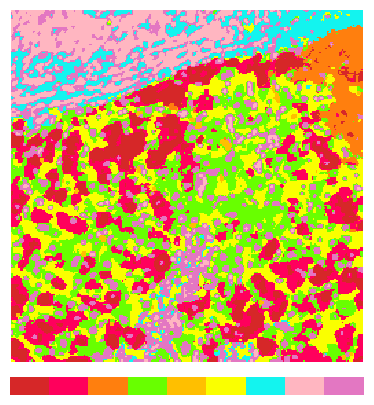

In [45]:
plotCluster(adata, color="louvain", location='bottom', cticks = False,save=f"spatial-smartgate.pdf")

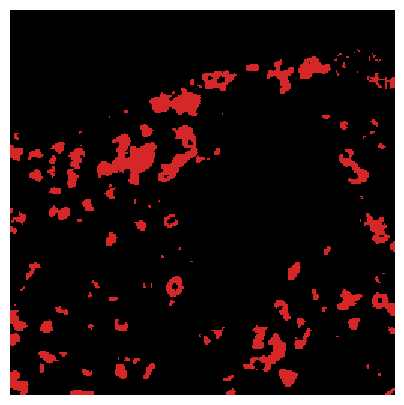

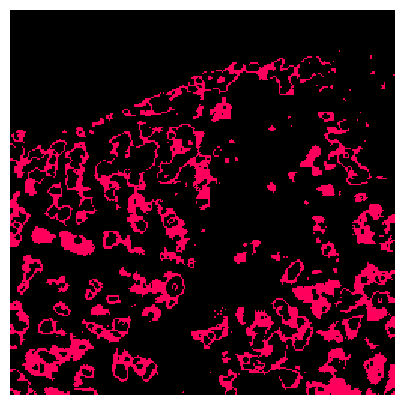

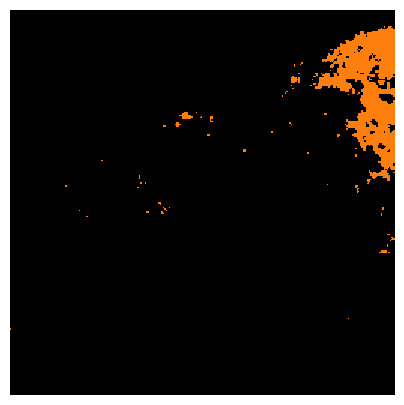

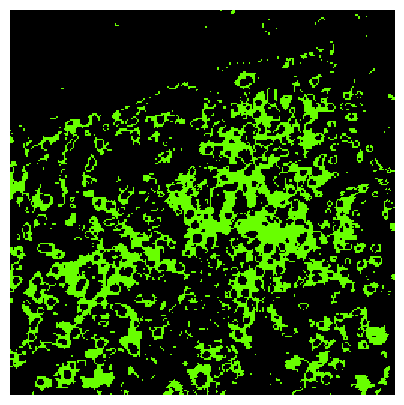

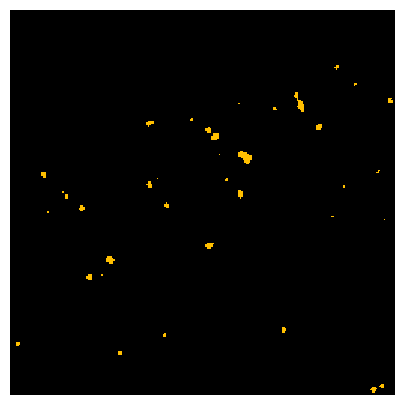

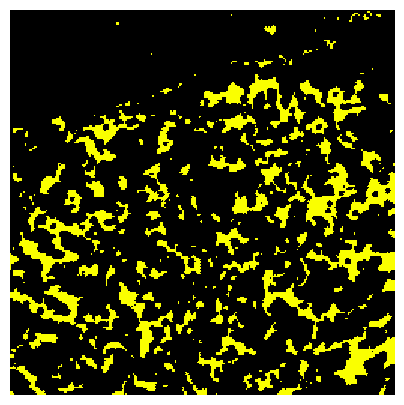

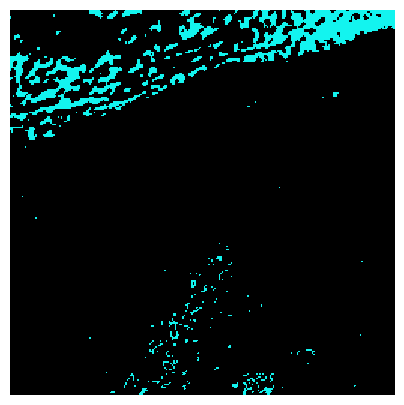

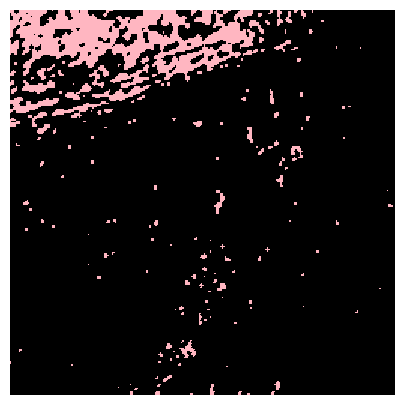

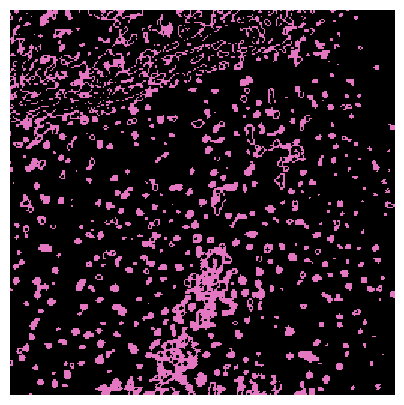

In [46]:
louvain_num = adata.obs['louvain'].value_counts().count() 

for i in range(louvain_num):
    plotCluster(adata, color='louvain', groups = [str(i)], location = 'bottom',
                cbar = False, cticks = False,
                save="spatial-smartgate-cluster{i}.pdf")

# marker ions

In [47]:
sc.tl.rank_genes_groups(adata,n_genes=adata.shape[1],groupby='louvain')
marker_ions_mtx = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
columns = marker_ions_mtx.columns
marker_ions = []
for c in columns:
    d = marker_ions_mtx[c].values.tolist()
    marker_ions += d
marker_ions_mtx

,1,2,3,4,5,6,7,8,9
0,59.3,59.3,281.81,79.27,77.31,98.38,91.33,79.27,79.27
1,71.33,71.33,279.79,153.43,60.28,100.34,107.35,63.25,63.25
2,69.31,69.31,255.75,140.44,76.31,84.34,66.3,134.45,134.45
3,87.35,58.29,71.33,111.4,61.28,91.33,50.27,181.39,181.39
4,55.29,55.29,59.3,70.34,63.25,70.34,100.34,159.39,90.35


In [48]:
#choose the unique marker ions
lst = []
for el in marker_ions:
    if lst.count(el) < 1:
        lst.append(el)
print(lst)
marker_ions_uni = lst

['59.3', '71.33', '69.31', '87.35', '55.29', '58.29', '281.81', '279.79', '255.75', '79.27', '153.43', '140.44', '111.4', '70.34', '77.31', '60.28', '76.31', '61.28', '63.25', '98.38', '100.34', '84.34', '91.33', '107.35', '66.3', '50.27', '134.45', '181.39', '159.39', '90.35']


In [52]:
marker_ions_main=['59.3','71.33','69.31','85.37','58.29', '281.81','279.79','255.75',
              '98.38', '100.34','84.34','70.34','124.41',
              '111.4','153.43','140.44', '122.4',  
              '91.33', '50.27', '75.31','80.29', 
              '63.25', '134.45', '181.39', '159.39', 
              '77.31', '60.28', '76.31', '61.28']

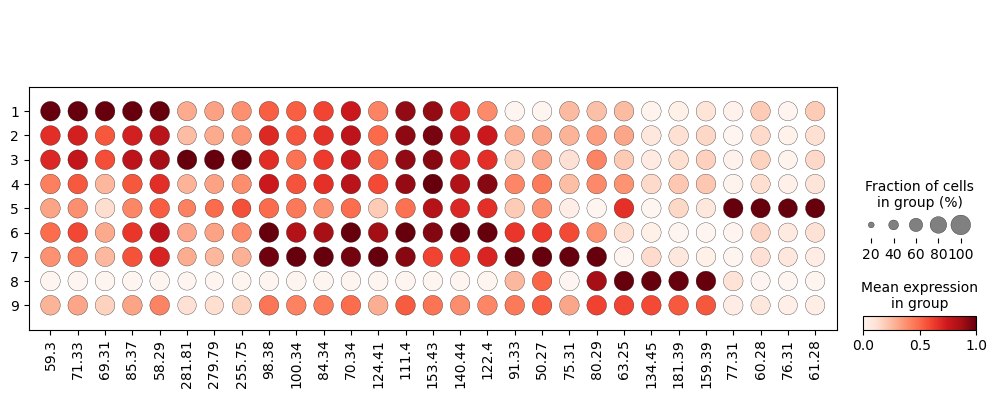

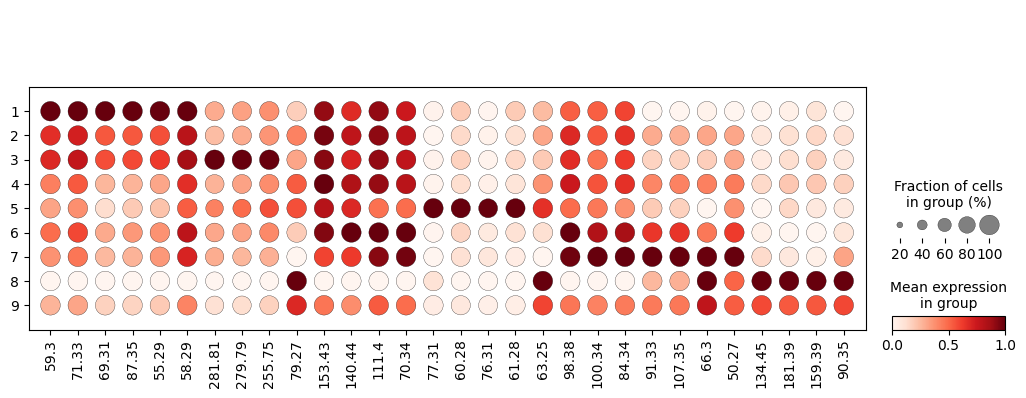

In [53]:
plt.rc('font', size=12) 
sc.pl.dotplot(adata, marker_ions_main, groupby='louvain',  dendrogram=False,  show = True, standard_scale='var', 
              save=f"dotplot_markerion_cluster.pdf")
sc.pl.dotplot(adata, marker_ions_uni, groupby='louvain',  dendrogram=False,  show = True, standard_scale='var', 
              save=f"dotplot_markerion_cluster_uni.pdf")

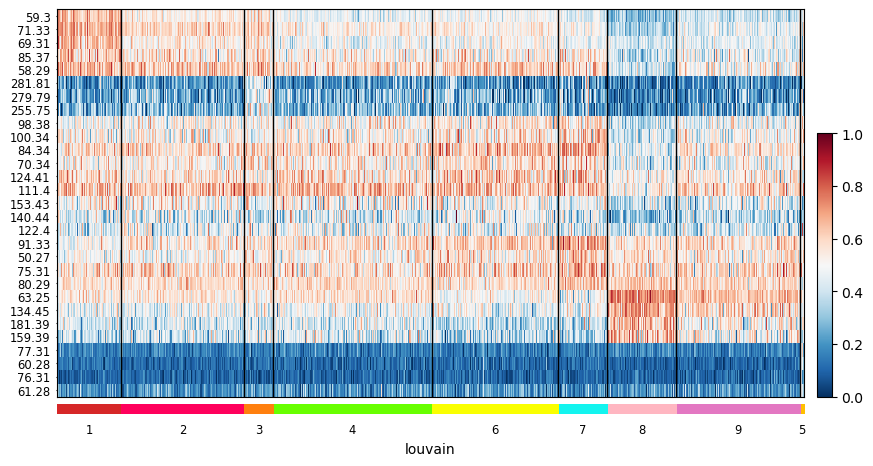

In [55]:
adata.obs['louvain'].cat.reorder_categories(['1','2','3','4','6','7','8','9','5'],inplace=True)
adata.uns['louvain_colors'] = [smtgt_cls[1], smtgt_cls[0], smtgt_cls[10], smtgt_cls[2], smtgt_cls[4], smtgt_cls[5],smtgt_cls[7],smtgt_cls[8],smtgt_cls[9]]

sc.pl.heatmap(adata, marker_ions_main, groupby='louvain', dendrogram=False, swap_axes=True, standard_scale='var',  cmap='RdBu_r', 
              show = True, save=f"-cluster_markerion.pdf")


## Compare the subclusters belonging to the same cell type

In [56]:
import numpy as np
from scipy.sparse import csr_matrix
adata_compare = adata.copy()
adata_compare.X = csr_matrix(adata_compare.X)
adata_compare

AnnData object with n_obs × n_vars = 65536 × 228
    obs: 'louvain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'STAGATE_attention', 'STAGATE_loss', 'Spatial_Net', 'hvg', 'louvain', 'louvain_colors', 'neighbors', 'umap', 'rank_genes_groups'
    obsm: 'STAGATE', 'X_umap', 'spatial', 'X_pca'
    layers: 'STAGATE_ReX'
    obsp: 'connectivities', 'distances'

In [57]:
mask = adata_compare.obs['louvain'].isin(['1','2'])
adata_compare.obs['louvain'] = adata_compare.obs['louvain'].cat.add_categories('12')
adata_compare.obs['louvain'][mask] = '12'
adata_compare.obs['louvain'] = adata_compare.obs['louvain'].cat.remove_unused_categories()
adata_compare.obs['louvain']

0         8
1         8
2         9
3         9
4         7
         ..
65531    12
65532    12
65533    12
65534    12
65535    12
Name: louvain, Length: 65536, dtype: category
Categories (8, object): ['3', '4', '6', '7', '8', '9', '5', '12']

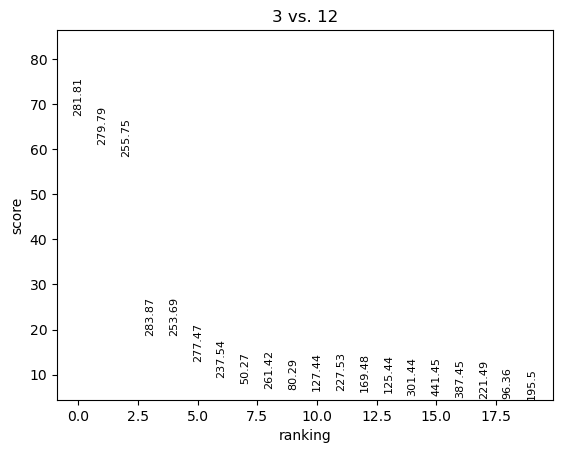

{'params': {'groupby': 'louvain',
  'reference': '12',
  'method': 't-test',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('281.81',), ('279.79',), ('255.75',), ('283.87',),
            ('253.69',), ('277.47',), ('237.54',), ('50.27',), ('261.42',),
            ('80.29',), ('127.44',), ('227.53',), ('169.48',), ('125.44',),
            ('301.44',), ('441.45',), ('387.45',), ('221.49',), ('96.36',),
            ('195.5',), ('425.46',), ('179.48',), ('481.48',), ('181.39',),
            ('295.47',), ('325.42',), ('159.39',), ('363.46',), ('51.28',),
            ('233.5',), ('299.6',), ('225.5',), ('211.52',), ('317.43',),
            ('151.45',), ('202.48',), ('285.4',), ('209.5',), ('206.49',),
            ('141.46',), ('62.29',), ('247.45',), ('537.43',), ('395.44',),
            ('521.45',), ('323.46',), ('190.47',), ('403.47',),
            ('126.42',), ('497.45',), ('365.46',), ('158.42',),
            ('170.47',), ('164.43',), ('2

In [58]:
sc.tl.rank_genes_groups(adata_compare, 'louvain', groups=['3'], reference='12', method='t-test')
sc.pl.rank_genes_groups(adata_compare, groups=['3'], n_genes=20)
adata_compare.uns['rank_genes_groups']

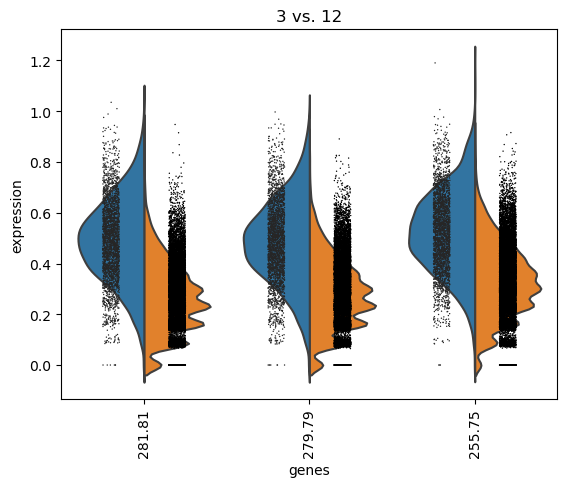

In [59]:
fig, ax = plt.subplots()
sc.pl.rank_genes_groups_violin(adata_compare, groups=['3'], gene_names=['281.81','279.79','255.75'],ax=ax) 